In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from pprint import pprint as pp

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [6]:
import importlib
from helper_methods import plot_confusion_matrices, make_dataframes_from_classification_report, plot_classification_report, plot_model_summary_metrics

In [7]:
#importlib.reload(helper_methods)

# OBJECTIVE
This work is the first pass at fitting classification models. All models use default parameter values; no tuning is done. The purpose is to get a general feel for accuracy and issues. These models were investigated:
- logistic regression
- SVM
- gaussian naive bayes
- multinomial naive bayes
- complement naive bayes

# CONCLUSIONS
1.logistic regression did not converge with default solver `lbfgs`; `sag` did converge

2.`SVC.fit` ran for 2.5 hours but did not complete. All other models finished in < 10 min. Perhaps there was a memory issue. I could not interrupt the kernel; had to shut it down completely.

3.gaussian NB has very large confusion among spruce_fir, lodgepole_pine, douglas_fir, and krummholz

4.model comparison
- gaussian NB has the worse performance
- muntinomial and complement NB have almost identical performance
- logistic regression has slightly better performance than NB
- each model's performance on the test data was similar to its performance on the train data
- weighted averages for precision, recall, and f1 are larger than the macro averages due to decreased emphasis on the poor performing small classes

5.performance by class
- each model has similar performance on the train and test data
- all models have difficulty with the 3 smallest classes (each present at <= 3%)
- complement NB has 0 predictions for aspen (present 1.7%) and cottonwood_willow (present 0.5%)
- gaussian NB has high recall for the 3 smallest classes but poor precision for them

# logical to control dataset sizes for modeling
### `True` gives very small train and test set sizes for developing and debugging notebook
### `False` splits entire dataset into train and test

In [8]:
#use_small_data_set = True
use_small_data_set = False

# read wrangled data from pickle

In [9]:
df_data = pd.read_pickle('/storage/wrangled_data.pkl')

In [10]:
df_data.shape
df_data.columns
df_data.head()

(581012, 68)

Index(['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology',
       'HD_roadways', 'hillshade_9am', 'hillshade_noon', 'hillshade_3pm',
       'HD_fire_points', 'wild_area_rawah', 'wild_area_neota',
       'wild_area_comanche_peak', 'wild_area_cache_la_poudre', 'soil_type_1',
       'soil_type_2', 'soil_type_3', 'soil_type_4', 'soil_type_5',
       'soil_type_6', 'soil_type_7', 'soil_type_8', 'soil_type_9',
       'soil_type_10', 'soil_type_11', 'soil_type_12', 'soil_type_13',
       'soil_type_14', 'soil_type_15', 'soil_type_16', 'soil_type_17',
       'soil_type_18', 'soil_type_19', 'soil_type_20', 'soil_type_21',
       'soil_type_22', 'soil_type_23', 'soil_type_24', 'soil_type_25',
       'soil_type_26', 'soil_type_27', 'soil_type_28', 'soil_type_29',
       'soil_type_30', 'soil_type_31', 'soil_type_32', 'soil_type_33',
       'soil_type_34', 'soil_type_35', 'soil_type_36', 'soil_type_37',
       'soil_type_38', 'soil_type_39', 'soil_type_40', 'cover_type',
       'wilder

,elevation,aspect,slope,HD_hydrology,VD_hydrology,HD_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,HD_fire_points,...,mms_elevation,mms_aspect,mms_slope,mms_HD_hydrology,mms_VD_hydrology,mms_HD_roadways,mms_hillshade_9am,mms_hillshade_noon,mms_hillshade_3pm,mms_HD_fire_points
0,2596,51,3,258,0,510,221,232,148,6279,...,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366
1,2590,56,2,212,-6,390,220,235,151,6225,...,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838
2,2804,139,9,268,65,3180,234,238,135,6121,...,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339
3,2785,155,18,242,118,3090,238,238,122,6211,...,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886
4,2595,45,2,153,-1,391,220,234,150,6172,...,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449


### define lists of column names

In [11]:
column = 'wild_area_'
areas = ['rawah', 'neota', 'comanche_peak', 'cache_la_poudre']
wild_area_cols = []
for i in areas:
    wild_area_cols.append(column + i)

column = 'soil_type_'
soil_type_cols = []
for i in range(1,41):
    soil_type_cols.append(column + str(i))

numerical_cols = ['elevation', 'aspect', 'slope', 'HD_hydrology', 'VD_hydrology', 'HD_roadways',
                  'hillshade_9am', 'hillshade_noon', 'hillshade_3pm', 'HD_fire_points']

scaled_numerical_cols = []
for col in numerical_cols:
    scaled_numerical_cols.append('mms_' + col)

target_col = ['cover_type']

target_names = ['spruce_fir', 'lodgepole_pine', 'ponderosa_pine', 'cottonwood_willow', 'aspen', 'douglas_fir', 'krummholz']

reverse_one_hot_cols = ['wilderness_index', 'wilderness_area', 'soil_index']

print('numerical_cols:')
pp(numerical_cols)

print('\nscaled_numerical_cols:')
pp(scaled_numerical_cols)

print('\nwild_area_cols:')
pp(wild_area_cols)

print('\nsoil_type_cols:')
pp(soil_type_cols)

print('\nreverse_one_hot_cols:')
pp(reverse_one_hot_cols)

print('\ntarget_col:')
pp(target_col)

print('\ntarget_names:')
pp(target_names)

numerical_cols:
['elevation',
 'aspect',
 'slope',
 'HD_hydrology',
 'VD_hydrology',
 'HD_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'HD_fire_points']

scaled_numerical_cols:
['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points']

wild_area_cols:
['wild_area_rawah',
 'wild_area_neota',
 'wild_area_comanche_peak',
 'wild_area_cache_la_poudre']

soil_type_cols:
['soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6',
 'soil_type_7',
 'soil_type_8',
 'soil_type_9',
 'soil_type_10',
 'soil_type_11',
 'soil_type_12',
 'soil_type_13',
 'soil_type_14',
 'soil_type_15',
 'soil_type_16',
 'soil_type_17',
 'soil_type_18',
 'soil_type_19',
 'soil_type_20',
 'soil_type_21',
 'soil_type_22',
 'soil_type_23',
 'soil_type_24',
 'soil_type_25',
 'soil_type_26',
 'soil_type_27',
 'soil_type_28',
 's

In [12]:
len(df_data.columns)

68

In [13]:
len(numerical_cols + scaled_numerical_cols + wild_area_cols + soil_type_cols + reverse_one_hot_cols + target_col)

68

In [14]:
feature_cols = scaled_numerical_cols + wild_area_cols + soil_type_cols
print('\nfeature_cols:')
pp(feature_cols)


feature_cols:
['mms_elevation',
 'mms_aspect',
 'mms_slope',
 'mms_HD_hydrology',
 'mms_VD_hydrology',
 'mms_HD_roadways',
 'mms_hillshade_9am',
 'mms_hillshade_noon',
 'mms_hillshade_3pm',
 'mms_HD_fire_points',
 'wild_area_rawah',
 'wild_area_neota',
 'wild_area_comanche_peak',
 'wild_area_cache_la_poudre',
 'soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6',
 'soil_type_7',
 'soil_type_8',
 'soil_type_9',
 'soil_type_10',
 'soil_type_11',
 'soil_type_12',
 'soil_type_13',
 'soil_type_14',
 'soil_type_15',
 'soil_type_16',
 'soil_type_17',
 'soil_type_18',
 'soil_type_19',
 'soil_type_20',
 'soil_type_21',
 'soil_type_22',
 'soil_type_23',
 'soil_type_24',
 'soil_type_25',
 'soil_type_26',
 'soil_type_27',
 'soil_type_28',
 'soil_type_29',
 'soil_type_30',
 'soil_type_31',
 'soil_type_32',
 'soil_type_33',
 'soil_type_34',
 'soil_type_35',
 'soil_type_36',
 'soil_type_37',
 'soil_type_38',
 'soil_type_39',
 'soil_type_40']


# function to get target name from target integer value

In [15]:
get_target_name_from_integer = lambda i : target_names[i-1]
get_target_name_from_integer(2)

'lodgepole_pine'

# train-test split

In [16]:
if use_small_data_set:
    train_sample_size = 10000
    test_sample_size  = 3000

    X_train, X_test, y_train, y_test = train_test_split(df_data[feature_cols], df_data[target_col[0]],
                                       train_size=train_sample_size, test_size=test_sample_size, random_state=59)

else:
    X_train, X_test, y_train, y_test = train_test_split(df_data[feature_cols], df_data[target_col[0]],
                                       train_size=0.7, random_state=59)
    

In [17]:
X_train.shape
X_test.shape

(406708, 54)

(174304, 54)

### distribution of target values

In [18]:
target_values = df_data[target_col]
target_dist_orig = target_values.value_counts() / len(target_values)
#target_dist_orig

target_values = pd.DataFrame(y_train)
target_dist_train = target_values.value_counts() / len(target_values)
#target_dist_train

target_values = pd.DataFrame(y_test)
target_dist_test = target_values.value_counts() / len(target_values)
#target_dist_test

df_target_dist = pd.DataFrame(zip(target_dist_orig, target_dist_train, target_dist_test),
                              columns=['original', 'train', 'test'],
                              index=target_dist_orig.reset_index()[target_col[0]].values)
#df_target_dist

df_target_dist = df_target_dist.reset_index().rename(columns={'index':target_col[0]})
#df_target_dist

df_target_dist['target_name'] = df_target_dist[target_col[0]].apply(get_target_name_from_integer)

df_target_dist

,cover_type,original,train,test,target_name
0,2,0.487599,0.487586,0.487631,lodgepole_pine
1,1,0.364605,0.364596,0.364627,spruce_fir
2,3,0.061537,0.061622,0.061341,ponderosa_pine
3,7,0.035300,0.035404,0.035059,krummholz
4,6,0.029891,0.029955,0.029741,douglas_fir
5,5,0.016339,0.016115,0.016861,aspen
6,4,0.004728,0.004723,0.004739,cottonwood_willow


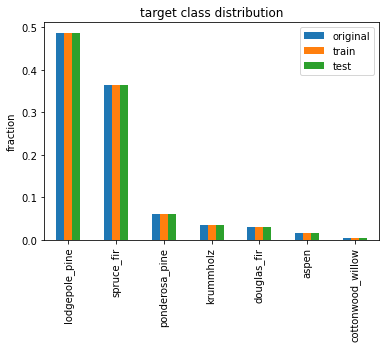

In [19]:
for_plot = ['target_name', 'original', 'train', 'test']
_ = df_target_dist[for_plot].set_index('target_name').plot.bar();
_ = plt.title('target class distribution');
_ = plt.xlabel('')
_ = plt.ylabel('fraction')

# variables to hold modeling results

In [20]:
df_report_by_class = pd.DataFrame()
df_report_summary  = pd.DataFrame()
y_pred_by_model = {}
list_model_names = []
list_the_models  = []

# logistic regression, `l2` regularization
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html   
defaults: `penalty='l2', C=1.0, solver='lbfgs'`   
for small dataset (10,000 train samples): get convegence with `max_iter=500,  solver='lbfgs'`   
large dataset does not converge with those settings so changed solver

In [21]:
model_name = 'log_reg'
list_model_names.append(model_name)

In [22]:
clf = LogisticRegression(solver='sag', max_iter=500, random_state=59)
clf.fit(X_train, y_train)

list_the_models.append(clf)

LogisticRegression(max_iter=500, random_state=59, solver='sag')

### predictions

In [23]:
y_train_pred = clf.predict(X_train)
y_test_pred  = clf.predict(X_test)

y_pred_by_model[model_name] = {'train':y_train_pred , 'test':y_test_pred}

### dataframe for classification report

In [24]:
df_by_class_train, df_summary_train = \
             make_dataframes_from_classification_report(model_name, 'train', target_names, y_train, y_train_pred)
df_by_class_test,  df_summary_test  = \
             make_dataframes_from_classification_report(model_name, 'test',  target_names, y_test,  y_test_pred )

df_by_class = df_by_class_train.append(df_by_class_test)
df_summary  = df_summary_train.append(df_summary_test)

df_report_by_class = df_report_by_class.append(df_by_class)
df_report_summary  = df_report_summary.append(df_summary)

df_report_by_class
df_report_summary

,model,data,class,precision,recall,f1-score,support
1,log_reg,train,spruce_fir,0.712260,0.698201,0.705160,148284
2,log_reg,train,lodgepole_pine,0.748260,0.801165,0.773809,198305
3,log_reg,train,ponderosa_pine,0.671055,0.823757,0.739606,25062
4,log_reg,train,cottonwood_willow,0.610749,0.390422,0.476342,1921
5,log_reg,train,aspen,0.194030,0.005951,0.011547,6554
6,log_reg,train,douglas_fir,0.494344,0.229582,0.313547,12183
7,log_reg,train,krummholz,0.730511,0.566845,0.638354,14399
1,log_reg,test,spruce_fir,0.710078,0.701051,0.705536,63556
2,log_reg,test,lodgepole_pine,0.748127,0.797814,0.772172,84996
3,log_reg,test,ponderosa_pine,0.667812,0.818088,0.735351,10692


,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
1,log_reg,train,0.724844,0.594458,0.502275,0.522624,0.712562,0.724844,0.714401
1,log_reg,test,0.723328,0.595514,0.500415,0.521290,0.710916,0.723328,0.712828


### investigate coefficient values

In [25]:
clf.coef_.shape

(7, 54)

In [26]:
clf.coef_[0]

array([ 2.03998940e+01, -5.54893111e-01,  4.18061601e-01, -1.37591892e+00,
       -2.40187529e+00, -1.27848586e+00, -1.08213938e+00, -4.74223435e+00,
        2.35581641e+00, -6.84051565e-01,  2.12587638e+00,  9.20237103e-01,
       -3.97496919e-01, -2.64683453e+00, -3.91934450e-02, -3.07999976e+00,
       -1.93598214e+00, -2.06826671e+00, -3.60650712e-02, -6.18936698e-01,
       -1.32218623e+00,  1.51902829e-01,  2.04055625e+00,  1.37847418e-01,
        1.15698271e-02,  1.35026577e+00, -1.04832368e-01, -1.36611572e-01,
       -2.05685094e-06,  9.49753173e-02, -1.00886716e+00,  4.57419648e-03,
        4.71309476e-01,  1.41240433e+00,  1.97489115e+00,  2.02305541e+00,
        8.61515541e-01,  9.44358472e-01,  9.65528172e-02,  4.02609997e-01,
        7.04679378e-01,  1.03129178e+00, -4.37010483e-02, -5.45624392e-01,
        1.07196025e+00, -1.98677862e-01,  8.19473528e-01, -1.35944086e+00,
        3.74145960e-01, -1.48221832e+00, -2.64884111e+00,  7.20897989e-02,
        4.39440452e-01,  

In [27]:
df_coef = pd.DataFrame(clf.coef_).transpose()
df_coef = df_coef.rename(columns=dict(zip(np.arange(7), target_names)))
df_coef.shape
df_coef.head(10)

(54, 7)

,spruce_fir,lodgepole_pine,ponderosa_pine,cottonwood_willow,aspen,douglas_fir,krummholz
0,20.399894,4.161385,-22.314433,-24.945028,-0.719541,-20.255707,43.673431
1,-0.554893,-0.496136,0.552828,0.227612,0.530410,0.120583,-0.380403
2,0.418062,1.510769,1.434256,-1.311670,1.806928,-2.282357,-1.575987
3,-1.375919,1.258313,5.013618,-2.373625,-0.254226,1.539902,-3.808062
4,-2.401875,-1.651082,0.836726,4.360334,2.131188,-0.488220,-2.787072
5,-1.278486,-0.598418,0.392689,6.653506,-4.209730,1.009966,-1.969527
6,-1.082139,-2.529643,-3.032965,3.960030,1.985391,3.391593,-2.692268
7,-4.742234,3.938009,4.426556,5.340303,1.495973,-8.581798,-1.876810
8,2.355816,-0.464787,-2.861313,-2.012269,-0.583161,5.795818,-2.230104
9,-0.684052,-0.966096,-2.342544,3.450219,-1.884449,0.552420,1.874501


### plot coefficient values

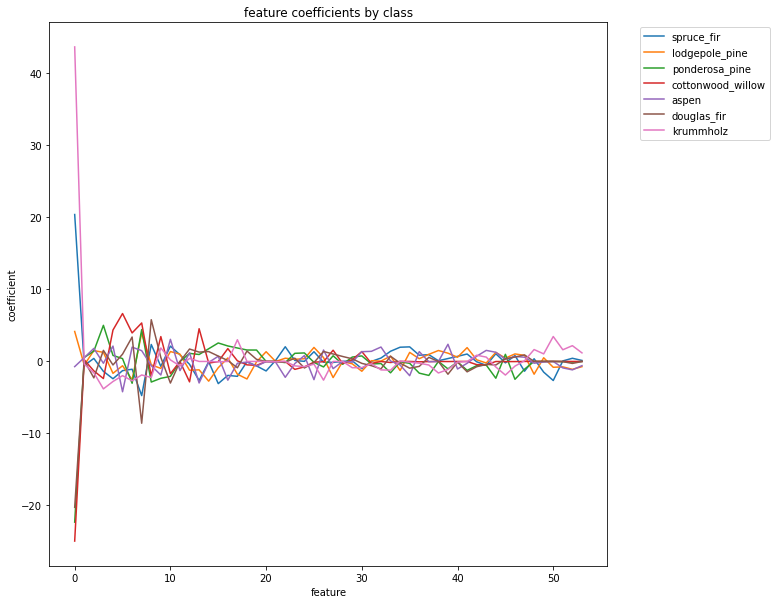

In [28]:
df_coef.plot(figsize=(10,10));
plt.xlabel('feature');
plt.ylabel('coefficient');
plt.title('feature coefficients by class');
plt.legend(bbox_to_anchor=(1.3,1), loc='upper right');

### get most and least important features

In [29]:
df_feature_importance = pd.DataFrame()
num_features = 3

for target_val in target_names:
    sorted_indices = df_coef[target_val].abs().sort_values(ascending=False).iondex
    #sorted_indices

    keys = []
    values = []

    for i in range(1,num_features+1):
        keys.append('top_'+str(i))
        values.append(feature_cols[sorted_indices[i-1]])

    for i in range(1,num_features+1):
        keys.append('bot_'+str(i))
        values.append(feature_cols[sorted_indices[-i]])

    dictionary_feature_importance = dict(zip(keys,values))
    #dictionary_feature_importance
    
    df_feature_importance = df_feature_importance.append(pd.DataFrame(dictionary_feature_importance, index=[target_val]))

df_feature_importance = df_feature_importance.reset_index().rename(columns={'index':target_col[0]})
df_feature_importance

,cover_type,top_1,top_2,top_3,bot_1,bot_2,bot_3
0,spruce_fir,mms_elevation,mms_hillshade_noon,soil_type_2,soil_type_15,soil_type_18,soil_type_11
1,lodgepole_pine,mms_elevation,mms_hillshade_noon,soil_type_1,soil_type_8,soil_type_15,soil_type_19
2,ponderosa_pine,mms_elevation,mms_HD_hydrology,mms_hillshade_noon,soil_type_37,soil_type_25,soil_type_7
3,cottonwood_willow,mms_elevation,mms_HD_roadways,mms_hillshade_noon,soil_type_37,soil_type_36,soil_type_35
4,aspen,mms_HD_roadways,wild_area_rawah,wild_area_cache_la_poudre,soil_type_15,soil_type_37,soil_type_25
5,douglas_fir,mms_elevation,mms_hillshade_noon,mms_hillshade_3pm,soil_type_37,soil_type_25,soil_type_7
6,krummholz,mms_elevation,mms_HD_hydrology,soil_type_37,soil_type_15,soil_type_14,soil_type_1


# SVM (support vector machine)
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html  
defaults: `kernel='rbf', C=1.0`   
`class_weight`: all classes have weight 1   
### result: ran 2.5 hrs and did not complete `fit`

In [ ]:
model_name = 'SVM'
list_model_names.append(model_name)

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)

list_the_models.append(svc)

### predictions

In [ ]:
y_train_pred = svc.predict(X_train)
y_test_pred  = svc.predict(X_test)

y_pred_by_model[model_name] = {'train':y_train_pred , 'test':y_test_pred}

### dataframes for classification report

In [ ]:
df_by_class_train, df_summary_train = \
             make_dataframes_from_classification_report(model_name, 'train', target_names, y_train, y_train_pred)
df_by_class_test,  df_summary_test  = \
             make_dataframes_from_classification_report(model_name, 'test',  target_names, y_test,  y_test_pred )

df_by_class = df_by_class_train.append(df_by_class_test)
df_summary  = df_summary_train.append(df_summary_test)

df_report_by_class = df_report_by_class.append(df_by_class)
df_report_summary  = df_report_summary.append(df_summary)

df_report_by_class
df_report_summary

# Gaussian Naive Bayes
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB  

In [30]:
model_name = 'Gaussian NB'
list_model_names.append(model_name)

In [31]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

list_the_models.append(gnb)

GaussianNB()

### predictions

In [32]:
y_train_pred = gnb.predict(X_train)
y_test_pred  = gnb.predict(X_test)

y_pred_by_model[model_name] = {'train':y_train_pred , 'test':y_test_pred}

### dataframes for classification report

In [33]:
df_by_class_train, df_summary_train = \
             make_dataframes_from_classification_report(model_name, 'train', target_names, y_train, y_train_pred)
df_by_class_test,  df_summary_test  = \
             make_dataframes_from_classification_report(model_name, 'test',  target_names, y_test,  y_test_pred )

df_by_class = df_by_class_train.append(df_by_class_test)
df_summary  = df_summary_train.append(df_summary_test)

df_report_by_class = df_report_by_class.append(df_by_class)
df_report_summary  = df_report_summary.append(df_summary)

df_report_by_class
df_report_summary

,model,data,class,precision,recall,f1-score,support
1,log_reg,train,spruce_fir,0.712260,0.698201,0.705160,148284
2,log_reg,train,lodgepole_pine,0.748260,0.801165,0.773809,198305
3,log_reg,train,ponderosa_pine,0.671055,0.823757,0.739606,25062
4,log_reg,train,cottonwood_willow,0.610749,0.390422,0.476342,1921
5,log_reg,train,aspen,0.194030,0.005951,0.011547,6554
6,log_reg,train,douglas_fir,0.494344,0.229582,0.313547,12183
7,log_reg,train,krummholz,0.730511,0.566845,0.638354,14399
1,log_reg,test,spruce_fir,0.710078,0.701051,0.705536,63556
2,log_reg,test,lodgepole_pine,0.748127,0.797814,0.772172,84996
3,log_reg,test,ponderosa_pine,0.667812,0.818088,0.735351,10692


,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
1,log_reg,train,0.724844,0.594458,0.502275,0.522624,0.712562,0.724844,0.714401
1,log_reg,test,0.723328,0.595514,0.500415,0.521290,0.710916,0.723328,0.712828
1,Gaussian NB,train,0.089502,0.234142,0.454281,0.126723,0.495877,0.089502,0.056101
1,Gaussian NB,test,0.089654,0.231855,0.454953,0.126746,0.489989,0.089654,0.055699


# Multinomial Naive Bayes
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB

In [34]:
model_name = 'Multinomial NB'
list_model_names.append(model_name)

In [35]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

list_the_models.append(mnb)

MultinomialNB()

### predictions

In [36]:
y_train_pred = mnb.predict(X_train)
y_test_pred  = mnb.predict(X_test)

y_pred_by_model[model_name] = {'train':y_train_pred , 'test':y_test_pred}

### dataframes for classification report

In [37]:
df_by_class_train, df_summary_train = \
             make_dataframes_from_classification_report(model_name, 'train', target_names, y_train, y_train_pred)
df_by_class_test,  df_summary_test  = \
             make_dataframes_from_classification_report(model_name, 'test',  target_names, y_test,  y_test_pred )

df_by_class = df_by_class_train.append(df_by_class_test)
df_summary  = df_summary_train.append(df_summary_test)

df_report_by_class = df_report_by_class.append(df_by_class)
df_report_summary  = df_report_summary.append(df_summary)

df_report_by_class
df_report_summary

,model,data,class,precision,recall,f1-score,support
1,log_reg,train,spruce_fir,0.712260,0.698201,0.705160,148284
2,log_reg,train,lodgepole_pine,0.748260,0.801165,0.773809,198305
3,log_reg,train,ponderosa_pine,0.671055,0.823757,0.739606,25062
4,log_reg,train,cottonwood_willow,0.610749,0.390422,0.476342,1921
5,log_reg,train,aspen,0.194030,0.005951,0.011547,6554
6,log_reg,train,douglas_fir,0.494344,0.229582,0.313547,12183
7,log_reg,train,krummholz,0.730511,0.566845,0.638354,14399
1,log_reg,test,spruce_fir,0.710078,0.701051,0.705536,63556
2,log_reg,test,lodgepole_pine,0.748127,0.797814,0.772172,84996
3,log_reg,test,ponderosa_pine,0.667812,0.818088,0.735351,10692


,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
1,log_reg,train,0.724844,0.594458,0.502275,0.522624,0.712562,0.724844,0.714401
1,log_reg,test,0.723328,0.595514,0.500415,0.521290,0.710916,0.723328,0.712828
1,Gaussian NB,train,0.089502,0.234142,0.454281,0.126723,0.495877,0.089502,0.056101
1,Gaussian NB,test,0.089654,0.231855,0.454953,0.126746,0.489989,0.089654,0.055699
1,Multinomial NB,train,0.643272,0.529667,0.418848,0.410140,0.634296,0.643272,0.618200
1,Multinomial NB,test,0.640215,0.523608,0.414267,0.405737,0.629968,0.640215,0.615031


# Complement Naive Bayes
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB 

In [38]:
model_name = 'Complement NB'
list_model_names.append(model_name)

In [39]:
cnb = ComplementNB()
cnb.fit(X_train, y_train)

list_the_models.append(cnb)

ComplementNB()

### predictions

In [40]:
y_train_pred = cnb.predict(X_train)
y_test_pred  = cnb.predict(X_test)

y_pred_by_model[model_name] = {'train':y_train_pred , 'test':y_test_pred}

### dataframes for classification report

In [41]:
df_by_class_train, df_summary_train = \
             make_dataframes_from_classification_report(model_name, 'train', target_names, y_train, y_train_pred)
df_by_class_test,  df_summary_test  = \
             make_dataframes_from_classification_report(model_name, 'test',  target_names, y_test,  y_test_pred )

df_by_class = df_by_class_train.append(df_by_class_test)
df_summary  = df_summary_train.append(df_summary_test)

df_report_by_class = df_report_by_class.append(df_by_class)
df_report_summary  = df_report_summary.append(df_summary)

df_report_by_class
df_report_summary

,model,data,class,precision,recall,f1-score,support
1,log_reg,train,spruce_fir,0.712260,0.698201,0.705160,148284
2,log_reg,train,lodgepole_pine,0.748260,0.801165,0.773809,198305
3,log_reg,train,ponderosa_pine,0.671055,0.823757,0.739606,25062
4,log_reg,train,cottonwood_willow,0.610749,0.390422,0.476342,1921
5,log_reg,train,aspen,0.194030,0.005951,0.011547,6554
6,log_reg,train,douglas_fir,0.494344,0.229582,0.313547,12183
7,log_reg,train,krummholz,0.730511,0.566845,0.638354,14399
1,log_reg,test,spruce_fir,0.710078,0.701051,0.705536,63556
2,log_reg,test,lodgepole_pine,0.748127,0.797814,0.772172,84996
3,log_reg,test,ponderosa_pine,0.667812,0.818088,0.735351,10692


,model,data,accuracy,macro_precision,macro_recall,macro_f1-score,weight_precision,weight_recall,weight_f1-score
1,log_reg,train,0.724844,0.594458,0.502275,0.522624,0.712562,0.724844,0.714401
1,log_reg,test,0.723328,0.595514,0.500415,0.521290,0.710916,0.723328,0.712828
1,Gaussian NB,train,0.089502,0.234142,0.454281,0.126723,0.495877,0.089502,0.056101
1,Gaussian NB,test,0.089654,0.231855,0.454953,0.126746,0.489989,0.089654,0.055699
1,Multinomial NB,train,0.643272,0.529667,0.418848,0.410140,0.634296,0.643272,0.618200
1,Multinomial NB,test,0.640215,0.523608,0.414267,0.405737,0.629968,0.640215,0.615031
1,Complement NB,train,0.620389,0.369426,0.402606,0.361811,0.605885,0.620389,0.602212
1,Complement NB,test,0.618110,0.371580,0.400840,0.361416,0.603380,0.618110,0.599984


# make plots for models

### scores by class

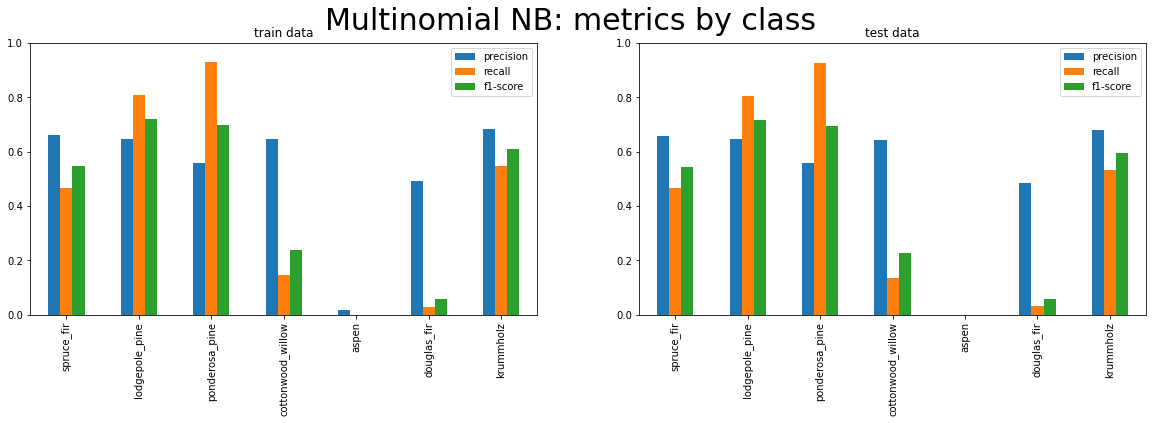

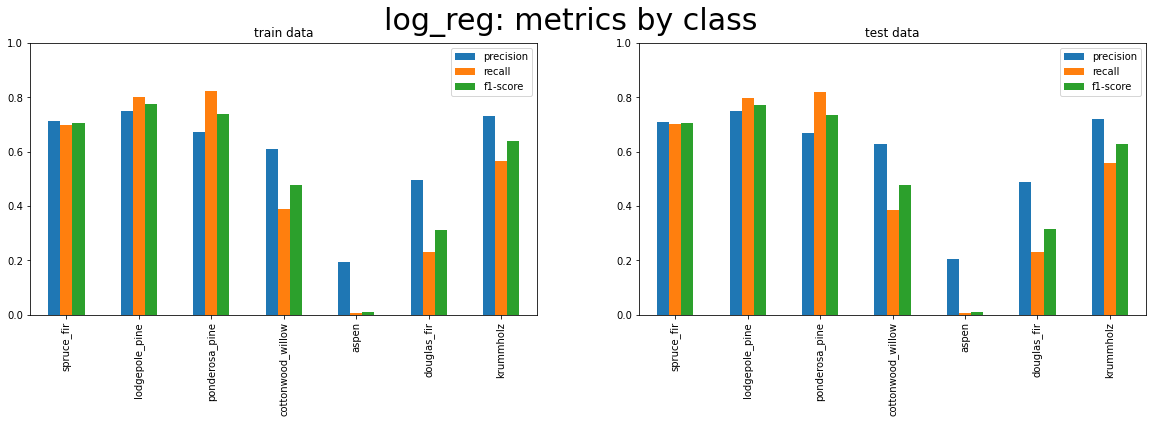

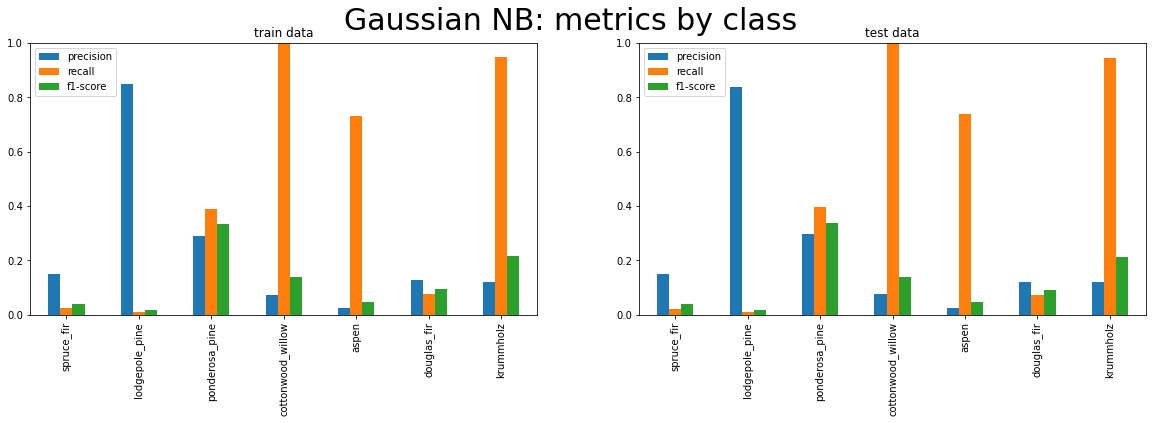

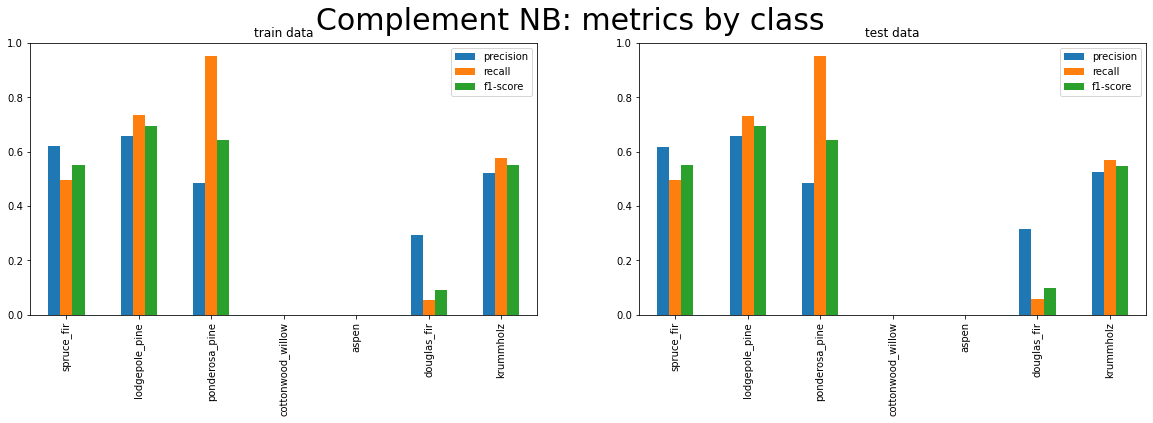

In [42]:
for model in list(df_report_by_class['model'].value_counts().index):
    plot_classification_report(model, df_report_by_class)

### confusion matrices

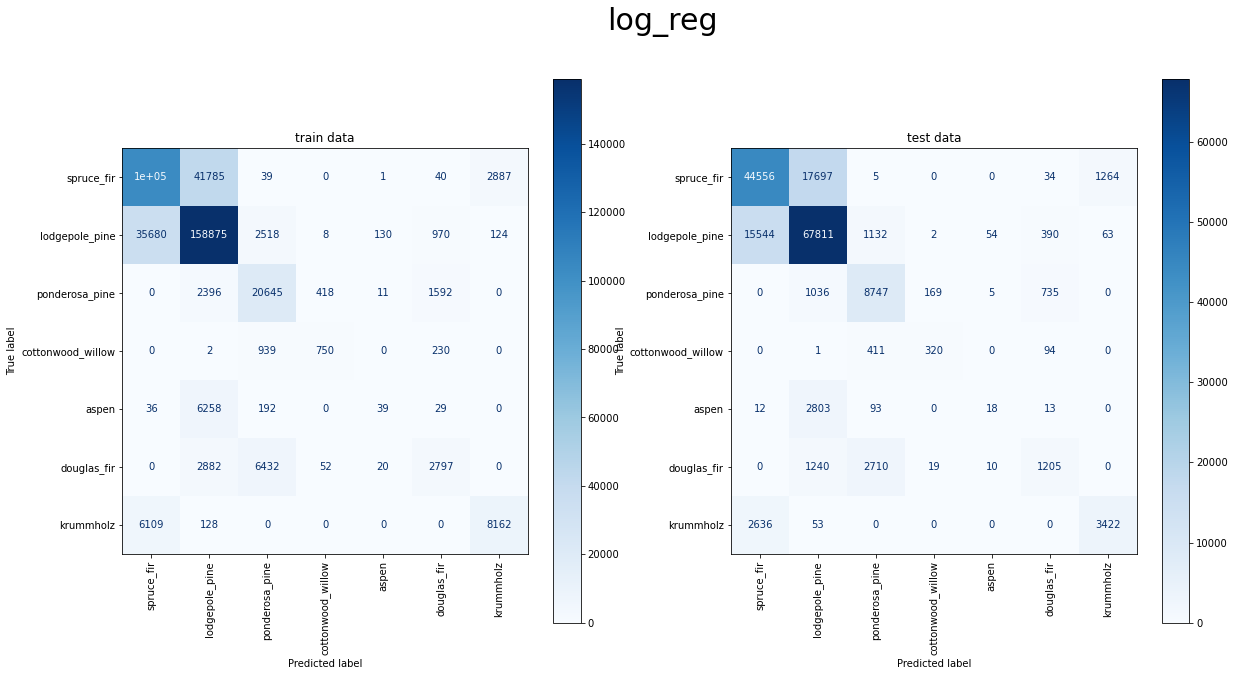

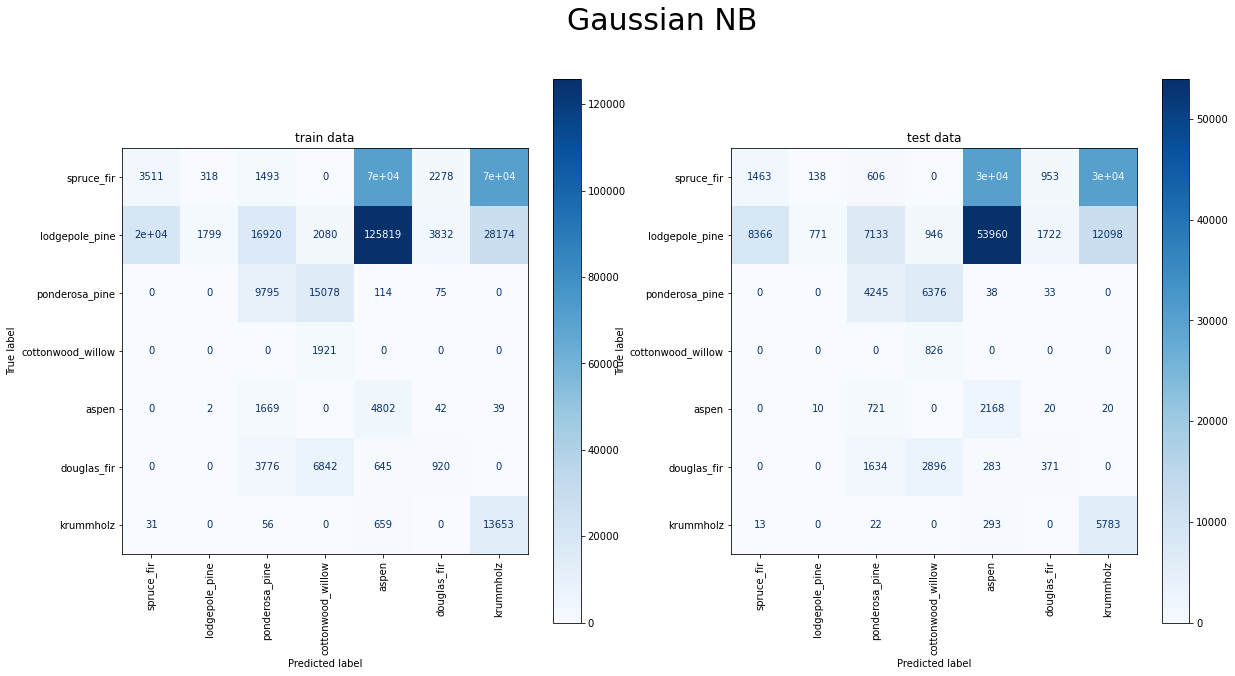

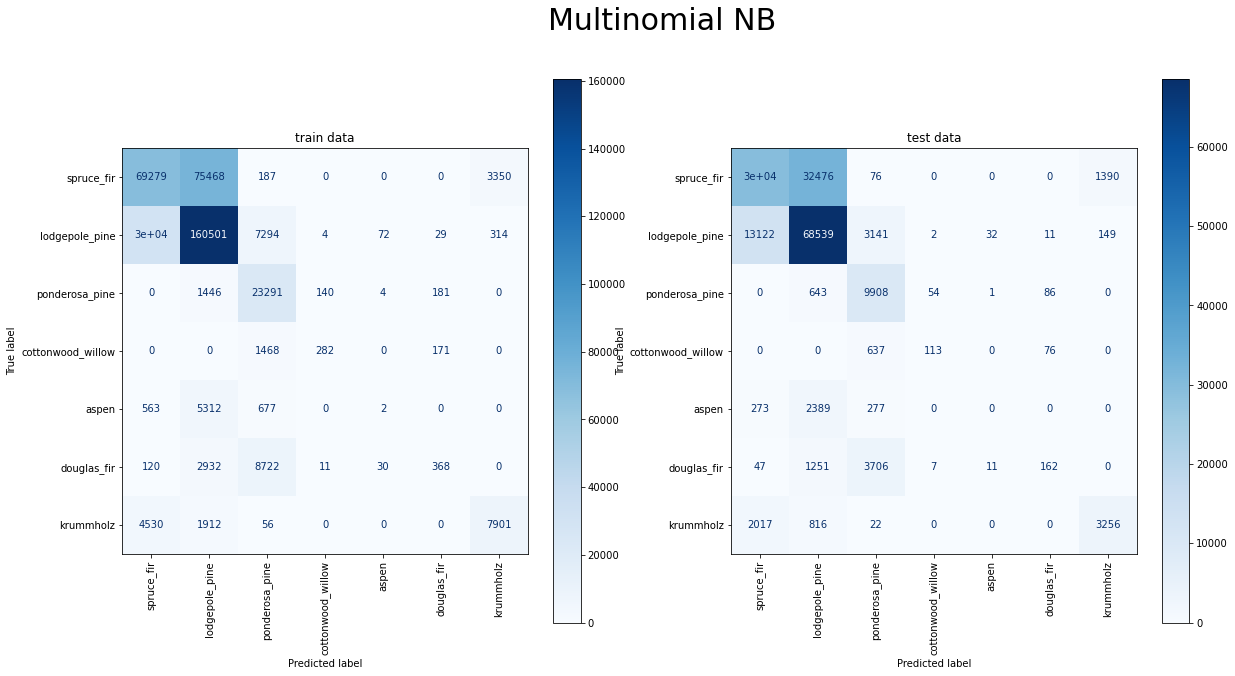

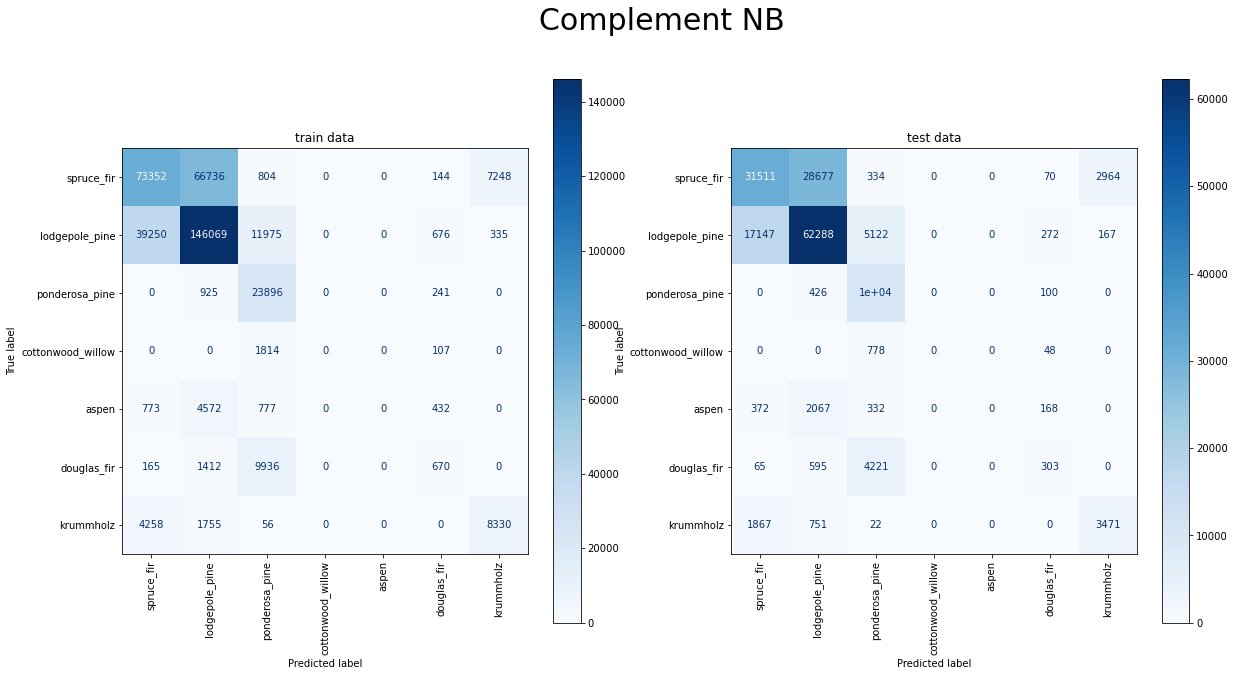

In [43]:
for (key, value) in y_pred_by_model.items():
    plot_confusion_matrices(key, y_train, value['train'], y_test, value['test'], target_names)

### summary of model metrics

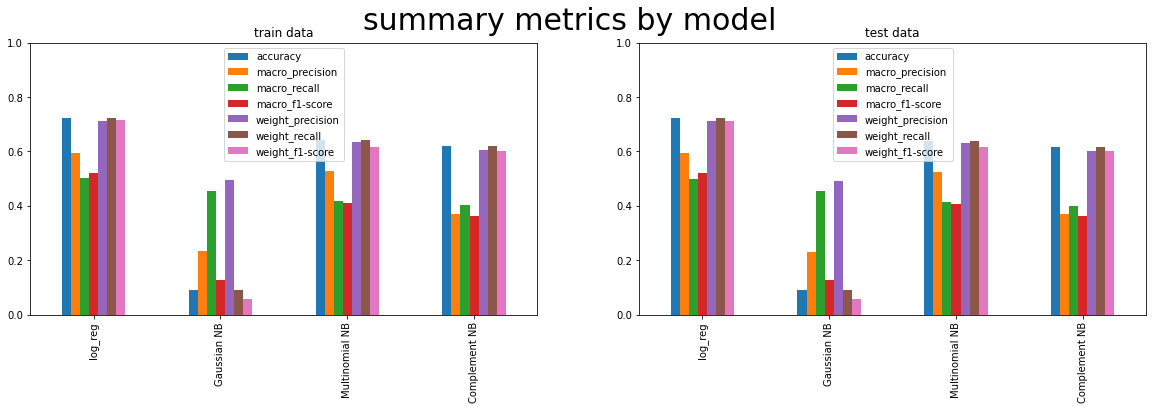

In [44]:
plot_model_summary_metrics(df_report_summary)

# CONCLUSIONS
1.logistic regression did not converge with default solver `lbfgs`; `sag` did converge

2.`SVC.fit` ran for 2.5 hours but did not complete. All other models finished in < 10 min. Perhaps there was a memory issue. I could not interrupt the kernel; had to shut it down completely.

3.gaussian NB has very large confusion among spruce_fir, lodgepole_pine, douglas_fir, and krummholz

4.model comparison
- gaussian NB has the worse performance
- muntinomial and complement NB have almost identical performance
- logistic regression has slightly better performance than NB
- each model's performance on the test data was similar to its performance on the train data
- weighted averages for precision, recall, and f1 are larger than the macro averages due to decreased emphasis on the poor performing small classes

5.performance by class
- each model has similar performance on the train and test data
- all models have difficulty with the 3 smallest classes (each present at <= 3%)
- complement NB has 0 predictions for aspen (present 1.7%) and cottonwood_willow (present 0.5%)
- gaussian NB has high recall for the 3 smallest classes but poor precision for them

# pickle models

### create dataframe

In [45]:
df_models_to_pickle = pd.DataFrame(data=zip(list_model_names, list_the_models), columns=['model_name', 'the_model'])
df_models_to_pickle

,model_name,the_model
0,log_reg,"LogisticRegression(max_iter=500, random_state=..."
1,Gaussian NB,GaussianNB()
2,Multinomial NB,MultinomialNB()
3,Complement NB,ComplementNB()


### write

In [46]:
df_models_to_pickle.to_pickle('/storage/preliminary_models_large.pkl')

### read file to be sure it's ok

In [47]:
df_models_read = pd.read_pickle('/storage/preliminary_models_large.pkl')
df_models_read

,model_name,the_model
0,log_reg,"LogisticRegression(max_iter=500, random_state=..."
1,Gaussian NB,GaussianNB()
2,Multinomial NB,MultinomialNB()
3,Complement NB,ComplementNB()


### try a prediction

In [48]:
dummy_predict = df_models_read['the_model'][0].predict(X_test)
dummy_predict

array([2, 3, 2, ..., 2, 2, 2])